In [1]:
import numpy as np
import glob
import random
from scipy import sparse

from tools.text_process import TfidfEncoder
from tools.image_process import getLayerNames, CategEncoder
from tools.joint_process import SimiEncoder

# random image generator, subject to rules
from tools.generator import ranGenLayer

class Dataset():
    def __init__(self, img_dir='images', txt_dir='text'):
        self.img_dir = img_dir
        self.txt_dir = txt_dir
        
        # fitting the vectorizer will process all the text
        # so we have double processed the text here
        self.img_encoder = CategEncoder()
        self.txt_encoder = TfidfEncoder()
        self.joint_encoder = SimiEncoder(self.img_encoder,
                                         self.txt_encoder)
        
        # set features
        self.features_ = []
        self.features_.extend(self.txt_encoder.vocab_)
        self.features_.extend(self.img_encoder.features_)
        self.features_.extend(self.joint_encoder.features_)
      
    def getOneLayerSent(self, txt_name=None, img_name=None,
                              ran_txt=False, ran_img=False,
                              fake_img=False):
        ##### preprocess
        ## text
        if ran_txt:
            all_txt = glob.glob(self.txt_dir+'/*.txt')
            # rule out current text
            all_txt.remove(txt_name)
            txt_name = random.choice(all_txt)
        else:
            assert(txt_name)
            
        with open(txt_name, 'r') as f:
            sent = f.read()
            
        ## image
        if ran_img:
            assert img_name
            assert not fake_img
            all_img = glob.glob(self.img_dir+'/*.svg')
            all_img.remove(img_name)
            img_name = random.choice(all_img)
            layers = getLayerNames(img_name)
        elif fake_img:
            assert img_name is None
            assert not ran_img
            layers = ranGenLayer()
        else:
            layers = getLayerNames(img_name)
            
        return layers, sent
        
    def encode(self, layers=None, sent=None, **kwargs):
        assert((layers and sent) or (not layers and not sent)), 'layers and sentence must be provided together, or neither'
        
        if not layers and not sent:
            layers, sent = self.getOneLayerSent(**kwargs)
        
        # tofeature
        txt_embed = self.txt_encoder.encode(sent)
        img_embed = self.img_encoder.encode(layers)
        joint_embed = self.joint_encoder.encode(layers, sent)
        
        return np.hstack([txt_embed, img_embed, joint_embed])        
    
    def __getitem__(self, ind):
        img_name = '%s/%i.svg' % (self.img_dir, ind+1)
        txt_name = '%s/%i.txt' % (self.txt_dir, ind+1)
        
        # triplets
        triplets = []
        # true match
        triplets.append(self.encode(txt_name=txt_name,
                                    img_name=img_name))
#         # fake image
#         triplets.append(self.encode(txt_name=txt_name,
#                                     fake_img=True))
        # mismatched text
        triplets.append(self.encode(img_name=img_name,
                                    txt_name=txt_name,
                                    ran_txt=True))
        # mismatched image
        triplets.append(self.encode(img_name=img_name,
                                    txt_name=txt_name,
                                    ran_img=True))
        
        xs = np.vstack(triplets)
        
        # ys
        # ys = np.array([1,0,0,0]).reshape(-1,1)
        ys = np.array([1,0,0]).reshape(-1,1)
        
        return sparse.csr_matrix(np.hstack([xs, ys]))
    
    def __len__(self):
        return len(glob.glob(self.img_dir+'/*.svg'))


In [2]:
dataset = Dataset()

/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: sideways with tag n does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: grid with tag a does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: cell with tag r does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: something with tag n does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: web with tag a does not belong

In [3]:
all_img = glob.glob(dataset.img_dir+'/*.svg')
layers = [getLayerNames(img_name) for img_name in all_img]

/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:42: UserWarning: In file images/43.svg layer A1 not at the same level with the first layer! Skip it!
  warnings.warn('In file %s layer %s not at the same level with the first layer! Skip it!' % (file, layer.getAttribute('id')))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:42: UserWarning: In file images/43.svg layer A2222 not at the same level with the first layer! Skip it!
  warnings.warn('In file %s layer %s not at the same level with the first layer! Skip it!' % (file, layer.getAttribute('id')))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:42: UserWarning: In file images/43.svg layer A323 not at the same level with the first layer! Skip it!
  warnings.warn('In file %s layer %s not at the same level with the first layer! Skip it!' % (file, layer.getAttribute('id')))


In [7]:
print(len(layers))
print(len(set([tuple(layer) for layer in layers])))

92
75


In [8]:
set([tuple(layer) for layer in layers])

{('A1', 'A2111', 'A311'),
 ('A1', 'A2114'),
 ('A1', 'A2114', 'A3211'),
 ('A1', 'A2114', 'A322'),
 ('A1', 'A2121', 'A313'),
 ('A1', 'A2121', 'A3212'),
 ('A1', 'A2121', 'A322'),
 ('A1', 'A2121', 'A323'),
 ('A1', 'A2121', 'A324'),
 ('A1', 'A2122', 'A311'),
 ('A1', 'A2122', 'A312'),
 ('A1', 'A2122', 'A3212'),
 ('A1', 'A2122', 'A3213'),
 ('A1', 'A2211', 'A315'),
 ('A1', 'A2212', 'A315'),
 ('A1', 'A222', 'A325', 'A4'),
 ('A1', 'A2221', 'A311'),
 ('A1', 'A2222', 'A311'),
 ('A1', 'A2222', 'A312'),
 ('A1', 'A2222', 'A314'),
 ('A1', 'A2222', 'A316'),
 ('A1', 'A2222', 'A3213'),
 ('A1', 'A2222', 'A323'),
 ('A1', 'A2222', 'A324'),
 ('A1', 'A2222', 'A325'),
 ('A1', 'A2222', 'A325', 'A4'),
 ('A1', 'A311'),
 ('A1', 'A312'),
 ('A1', 'A314'),
 ('A1', 'A316'),
 ('A1', 'A323'),
 ('A1', 'A323', 'A2222'),
 ('A1', 'A325'),
 ('A2111', 'A322'),
 ('A2112', 'A311'),
 ('A2113', 'A311'),
 ('A2114',),
 ('A2114', 'A311'),
 ('A2114', 'A316'),
 ('A2121',),
 ('A2121', 'A311'),
 ('A2121', 'A3211'),
 ('A2121', 'A3213'),


In [ ]:
class DatasetReality(Dataset):
    
    def __getitem__(self, ind):
        img_name = '%s/%i.svg' % (self.img_dir, ind+1)
        
        # triplets
        triplets = []
        # true match
        triplets.append(self.encode(txt_name=txt_name,
                                    img_name=img_name))
#         # fake image
#         triplets.append(self.encode(txt_name=txt_name,
#                                     fake_img=True))
        # mismatched text
        triplets.append(self.encode(img_name=img_name,
                                    txt_name=txt_name,
                                    ran_txt=True))
        # mismatched image
        triplets.append(self.encode(img_name=img_name,
                                    txt_name=txt_name,
                                    ran_img=True))
        
        xs = np.vstack(triplets)
        
        # ys
        # ys = np.array([1,0,0,0]).reshape(-1,1)
        ys = np.array([1,0,0]).reshape(-1,1)
        
        return sparse.csr_matrix(np.hstack([xs, ys]))        
        
    

In [135]:
def sparse_shuffle(X, interval=4):
    assert(isinstance(X, sparse.csr.csr_matrix))
#     index = np.arange(X.shape[0])
#     np.random.shuffle(index)
#     return X[index]

    index_split = np.array_split(np.arange(X.shape[0]),
                                 X.shape[0]/interval)
    np.random.shuffle(index_split)
    return X[np.hstack(index_split)]

In [137]:
dataset = Dataset()
print('# features: ', len(dataset.features_))
data = sparse.vstack([dataset[i] for i in range(len(dataset))])
# recall can be very high if not shuffle the data, why?
data = sparse_shuffle(data, interval=3)
X, y = data[:,:-1], data[:,-1]
y = y.toarray().flatten()
print('data shape', data.shape)

# features:  11430


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:42: UserWarning: In file images/43.svg layer A1 not at the same level with the first layer! Skip it!
  warnings.warn('In file %s layer %s not at the same level with the first layer! Skip it!' % (file, layer.getAttribute('id')))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:42: UserWarning: In file images/43.svg layer A2222 not at the same level with the first layer! Skip it!
  warnings.warn('In file %s layer %s not at the same level with the first layer! Skip it!' % (file, layer.getAttribute('id')))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/image_process.py:42: UserWarning: In file images/43.svg layer A323 not at the same level with the first layer! Skip it!
  warnings.warn('In file %s layer %s not at the same level with the first layer! Skip it!' % (file, layer.getAttribute('id')))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: sid

data shape (276, 11431)


In [138]:
layers, sentence = dataset.getOneLayerSent(txt_name='text/1.txt',
                                       img_name='images/6.svg')
print(layers)
print(dataset.img_encoder.layer2keyword(layers))
print(sentence)
list(filter(lambda x: x[1]!=0, zip(dataset.joint_encoder.features_, dataset.joint_encoder.encode(layers, sentence))))

['A2112', 'A311']
['indoor.a.01', 'object.n.01', 'appliance.n.02', 'interaction.n.01', 'occupation.n.01']
A man looks at his chart with his back.



[('_S_object.n.01_back.n.01_', 1.845826690498331),
 ('_S_object.n.01_chart.n.01_', 1.6916760106710724),
 ('_S_object.n.01_man.n.01_', 1.845826690498331),
 ('_S_appliance.n.02_back.n.01_', 1.1526795099383855),
 ('_S_appliance.n.02_chart.n.01_', 1.072636802264849),
 ('_S_appliance.n.02_man.n.01_', 1.2396908869280152),
 ('_P_interaction.n.01_back.n.01_', 1.1526795099383855),
 ('_P_interaction.n.01_chart.n.01_', 1.4403615823901665),
 ('_P_interaction.n.01_man.n.01_', 1.1526795099383855),
 ('_P_occupation.n.01_back.n.01_', 1.1526795099383855),
 ('_P_occupation.n.01_chart.n.01_', 1.4403615823901665),
 ('_P_occupation.n.01_man.n.01_', 1.1526795099383855)]

In [149]:
from sklearn.linear_model import LogisticRegression
# higher class weight of 0 will always make it easier in term of precision
# because of imbalance
clf = LogisticRegression(# random_state=0,
                         solver='liblinear',
                         class_weight={1: 1, 0:0.3},
                         penalty='l1', #'l2' use l1 to learn sparsely
                         C=1.0,
                         max_iter=1000)

interval = 3 #4
ind_test = int(X.shape[0]/interval * 0.9) * interval
print('# train: ', ind_test)
print('# test: ', X.shape[0] - ind_test)
clf.fit(X[:ind_test], y[:ind_test])
# clf.fit(X, y)

# train:  246
# test:  30


LogisticRegression(C=1.0, class_weight={0: 0.3, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy: 0.600000
# 10 positives out of 30
Recall(thresh=0.5)/AccuracyOf1: 0.600000
Precision(thresh=0.5): 0.428571
AccuracyOf0(thresh=0.5): 0.600000


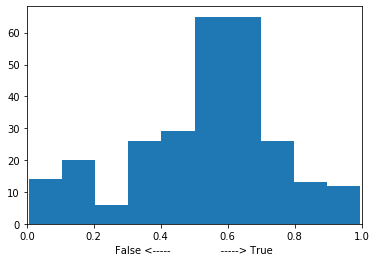

In [150]:
import matplotlib.pyplot as plt

print('Accuracy: %.6f' % clf.score(X[ind_test:],y[ind_test:]))
y_true = y[ind_test:]
y_pred = clf.predict(X[ind_test:])
print('# %i positives out of %i' % (sum(y_true), len(y_true)))
recall = sum(np.logical_and(y_pred == y_true, y_true)) / sum(y_true)
precision = sum(np.logical_and(y_pred == y_true, y_true)) / sum(y_pred)
acc0 = sum(np.logical_and(y_pred == y_true, 1-y_true)) / sum(1-y_true)
print('Recall(thresh=0.5)/AccuracyOf1: %.6f' % recall)
print('Precision(thresh=0.5): %.6f' % precision)
print('AccuracyOf0(thresh=0.5): %.6f' % acc0)
# print(clf.predict(X))
# print(clf.predict_proba(X)[:,1])
# print(y)
plt.hist(clf.predict_proba(X)[:,1])
plt.xlabel('False <-----                -----> True')
plt.xlim([0, 1])
plt.show()

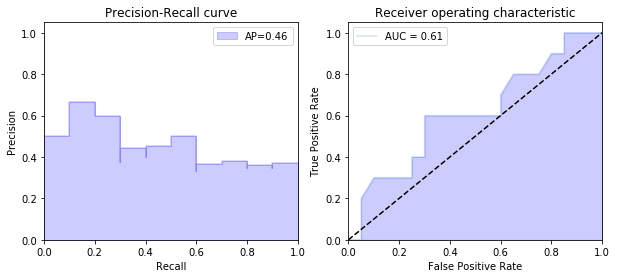

In [193]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from inspect import signature

y_true = y[ind_test:]
y_prob = clf.predict_proba(X[ind_test:])[:,1]
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
precision, recall, thresholds = precision_recall_curve(y_true,
                                                       y_prob)
ap = average_precision_score(y[ind_test:], clf.predict_proba(X[ind_test:])[:,1])
# print(thresholds)
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, 
                 color='b', **step_kwargs, 
                 label='AP={0:0.2f}'.format(ap))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")

plt.subplot(1,2,2)
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, alpha=0.2,
         label='AUC = %0.2f' % auc(fpr, tpr))
plt.fill_between(fpr, tpr, alpha=0.2, color='b')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver operating characteristic')
plt.legend(loc="upper left")

plt.show()

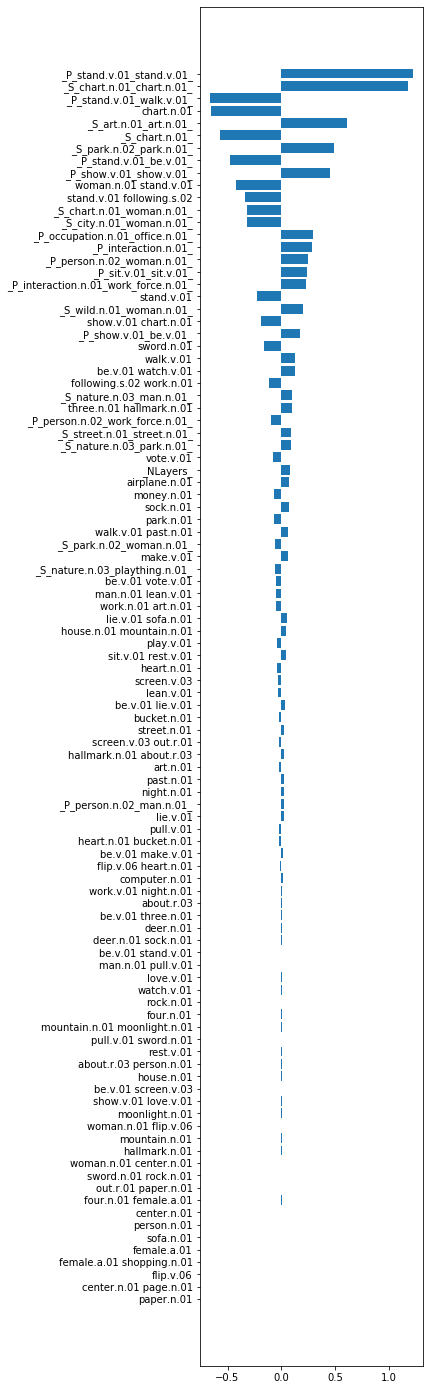

In [194]:
d = dict(zip(dataset.features_, clf.coef_.tolist()[0]))
d_filter = filter(lambda x: x[1] != 0, d.items())
feat, valv = zip(*sorted(d_filter, key=lambda x: abs(x[1])))
plt.figure(figsize=(4,25))
plt.barh(feat, valv)
plt.show()

In [118]:
# todo - unseen keywords

In [119]:
# brutal-force search

In [11]:
from tools.generator import getAllLayerCombs
all_layers = getAllLayerCombs()
assert(len(all_layers) == 11*4+13*4+11*13*4*2)
from tools.image_process import checkLayerNames
for layer in all_layers:
    checkLayerNames(layer)

In [207]:
def exhaustiveSearch(query_txt):
    print('text: %s' % query_txt)
    print('tokens:', dataset.txt_encoder.tokenizer(query_txt))
    probs = []
    for i, layers in enumerate(all_layers):
        print('[%i]' % i, end='\r')
        X = dataset.encode(sent=query_txt, layers=layers)
        probs.append((i, np.squeeze(clf.predict_proba(X.reshape(1,-1)))[1]))
    imax, max_prob = max(probs, key=lambda x: x[1])
    max_layers = all_layers[imax]
    print('Most consistent layer:', max_layers, 'Prob: %.6f' % max_prob)
    print('Corresponding keywords:', dataset.img_encoder.layer2keyword(max_layers))
    return max_layers

In [208]:
layers = exhaustiveSearch('A man plays in a park.')

text: A man plays in a park.
tokens: ['man.n.01', 'play.v.01', 'park.n.01']
Most consistent layer: ['A1', 'A2221', 'A311', 'A4'] Prob: 0.846374
Corresponding keywords: ['outdoor.a.01', 'nature.n.03', 'park.n.02', 'interaction.n.01', 'occupation.n.01']


In [213]:
def getMaterial(layer):
    l = glob.glob('material/%s*.png' % layer)
    return random.choice(l)

from tools.image_process import stack_svgs
stack_svgs([getMaterial(layer) for layer in layers])

from IPython.display import SVG, display
from IPython.display import HTML
def show_svg():
    # display(HTML("<style>.container { width:100% !important; }</style>"))
    # style = "<style>svg{width:50% !important;height:50% !important;}</style>"
    # display(HTML(style))
    display(SVG('stack.svg'))
show_svg()

Canvas size: (1116, 947)
File: material/A1_(13).png
File: material/A2221_(4).png
File: material/A311_(11).png
File: material/A4.png
